In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.signal
import math
from colorama import Fore, Style

from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

### Reading the data
The training data has 64320 rows, corresponding to 670 days with 24*4 rows per day. The test data has 5360 rows corresponding to almost 56 days (the final day ends at 7:45 pm).

In [2]:
train = pd.read_csv('data/train.csv', index_col='id', parse_dates=['date'])
test = pd.read_csv('data/test.csv', index_col='id', parse_dates=['date'])

features = list(test.columns[1:]) # without date column

if not train.isna().any().any():
    print('There are no missing values in train.')
if not test.isna().any().any():
    print('There are no missing values in test.')
    
print(f"Train shape: {train.shape}   test shape: {test.shape}")

train

There are no missing values in train.
There are no missing values in test.
Train shape: (64320, 8)   test shape: (5360, 7)


,date,feature_AA,feature_AB,feature_BA,feature_BB,feature_CA,feature_CB,Temperature
id,,,,,,,,
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 00:15:00,5.760,2.076,1.492,0.426,4.264,1.401,30.459999
2,2016-07-01 00:30:00,5.760,1.942,1.492,0.391,4.234,1.310,30.038000
3,2016-07-01 00:45:00,5.760,1.942,1.492,0.426,4.234,1.310,27.013000
4,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
...,...,...,...,...,...,...,...,...
64315,2018-05-01 22:45:00,12.458,1.407,7.889,-0.746,4.843,1.523,10.622000
64316,2018-05-01 23:00:00,14.200,1.541,9.310,0.284,4.752,1.249,10.482000
64317,2018-05-01 23:15:00,12.659,1.474,7.924,-0.959,4.569,1.310,10.271000


Let's just confirm that every quarter of an hour is covered by the datasets:

In [3]:
if ((train.date - train.date.shift(1)).iloc[1:] == pd.to_timedelta(15, unit='m')).all():
    print('Train has a sample every 15 minutes.')
if ((test.date - test.date.shift(1)).iloc[1:] == pd.to_timedelta(15, unit='m')).all():
    print('Test has a sample every 15 minutes.')

Train has a sample every 15 minutes.
Test has a sample every 15 minutes.


### A first look at the data¶
As we are working with a time series dataset, we of course start by plotting all features and the target against time.

The diagram of the seven time series shows:

* feature_AA and feature_BA have low variance in 2016 and higher variance later.
* feature_AA and feature_BA look correlated.
* feature_AB and feature_BB look correlated.
* feature_CB has some outlier periods.
* **Temperature is higher in summer than in winter (seasonality).**
* **The temperature has a downward trend.**
* And it looks like during the first year the temperature is noisier than during the second year (heteroscedasticity).

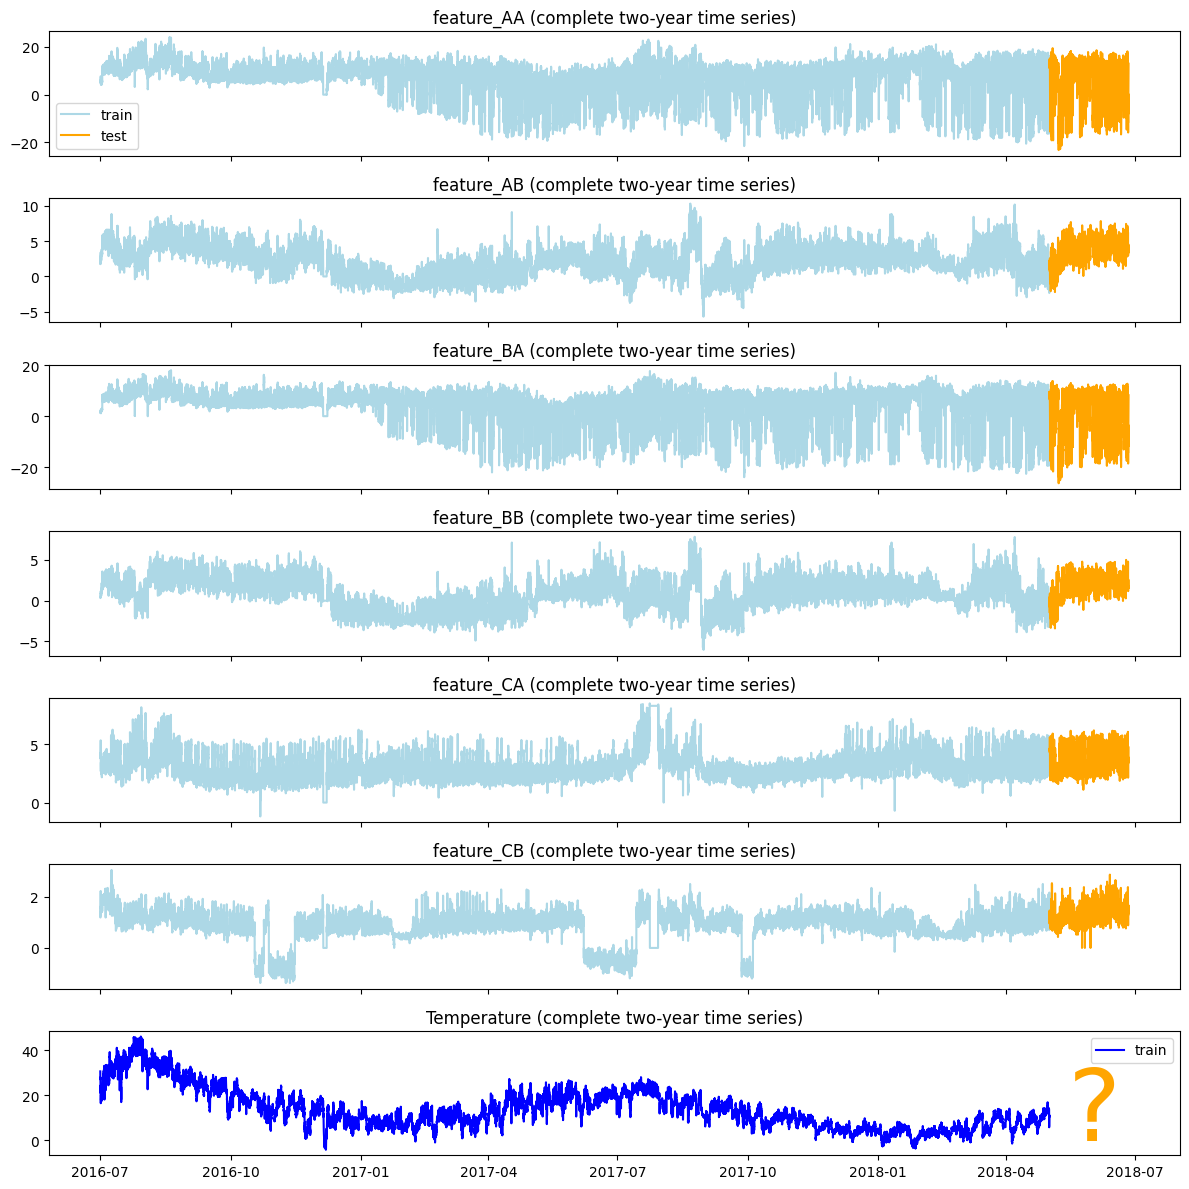

In [4]:
_, axs = plt.subplots(7, 1, sharex=True, figsize=(12, 12))
for ax, col in zip(axs, features + ['Temperature']):
    ax.set_title(f"{col} (complete two-year time series)")
    ax.plot(train.date, train[col], label='train', color='lightblue' if col != 'Temperature' else 'b')
    if col != 'Temperature':
        ax.plot(test.date, test[col], label='test', color='orange')
    else:
        ax.text(pd.to_datetime('2018-05-15'), 0, '?', fontsize=72, color='orange')
    if col in ['feature_AA', 'Temperature']:
        ax.legend()
plt.tight_layout()
plt.show()

Let's zoom into the first week of the time series. What can we see?

* Some correlation among the features is still visible.
* feature_CA exhibits a daily pattern.

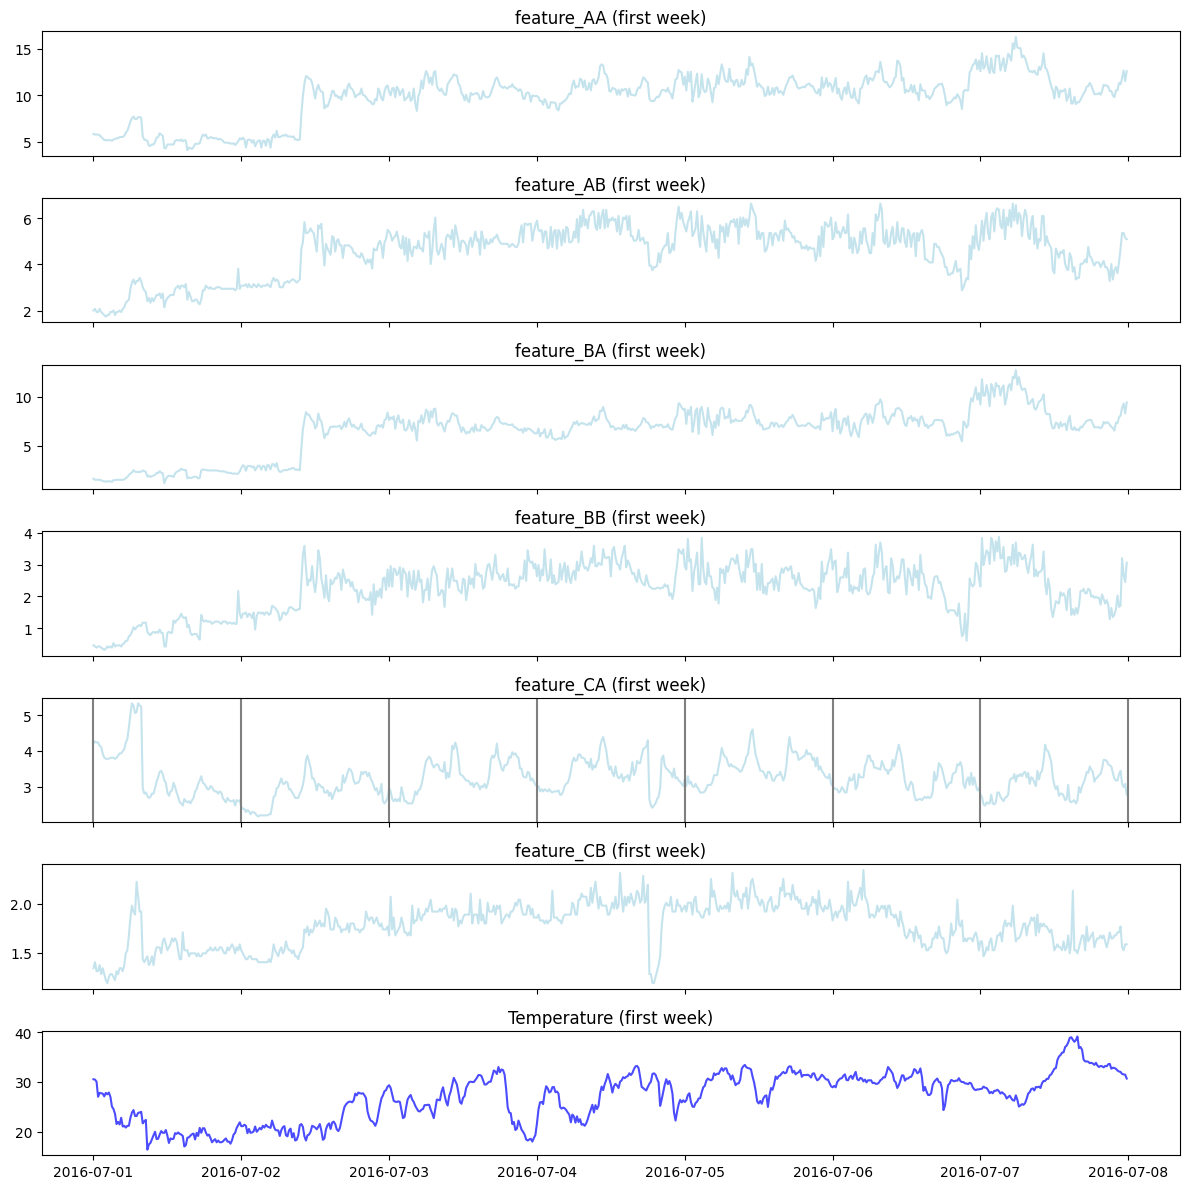

In [5]:
temp = train.iloc[:7*24*4]
_, axs = plt.subplots(7, 1, sharex=True, figsize=(12, 12))
for ax, col in zip(axs, features + ['Temperature']):
    ax.set_title(f"{col} (first week)")
    ax.plot(temp.date, temp[col], label='train', alpha=0.7, 
            color='lightblue' if col != 'Temperature' else 'b')
    if col == 'feature_CA':
        for x in pd.date_range(start=train.iloc[0].date, periods=8, freq='d'):
            ax.axvline(x, color='gray')
plt.tight_layout()
plt.show()

### Feature correlation¶
The correlation matrix confirms the correlations seen above, but I don't know yet what to make of this information. It's just another useless heatmap...

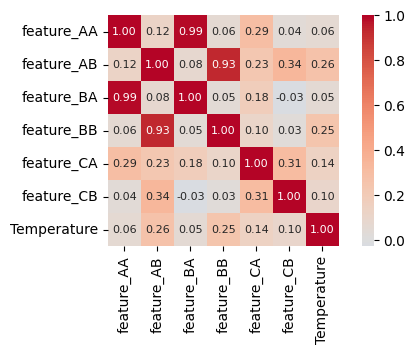

In [6]:
plt.figure(figsize=(6, 3))
corr = np.corrcoef(train[features + ['Temperature']], rowvar=False)
sns.heatmap(corr, cmap='coolwarm', center=0,
            xticklabels=features + ['Temperature'],
            yticklabels=features + ['Temperature'],
            annot=True, fmt='.2f', annot_kws={'fontsize': 8})
plt.gca().set_aspect('equal')
plt.show()

### Periodograms¶
A periodogram serves to identify the important frequencies in a time series.

The periodograms of all features show a strong peak at a frequency of 365/year (i.e., a period of one day) (and multiples of this frequency). The temperature periodogram additionally shows a strong peak at 1/year (i.e., a period of one year).

Insight: For some models, we need to add features which account for the daily and yearly periodicity of the target.

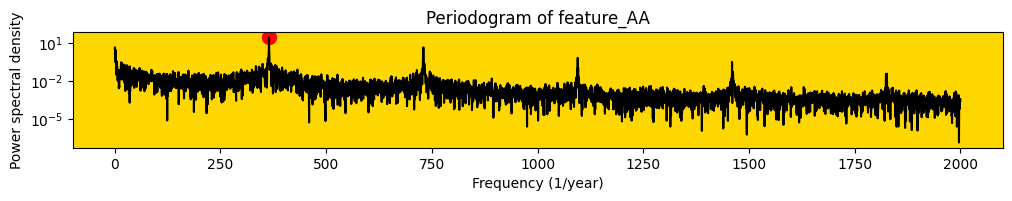

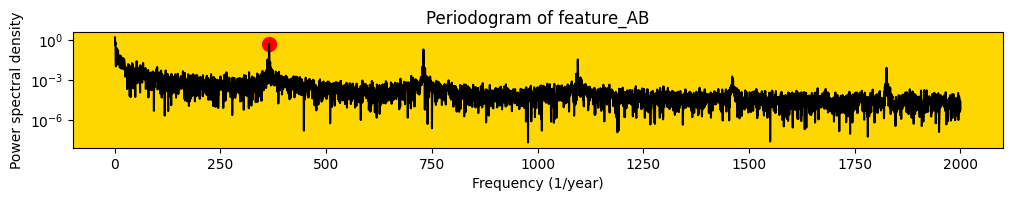

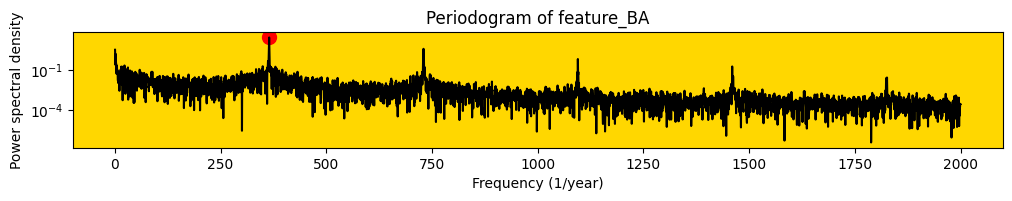

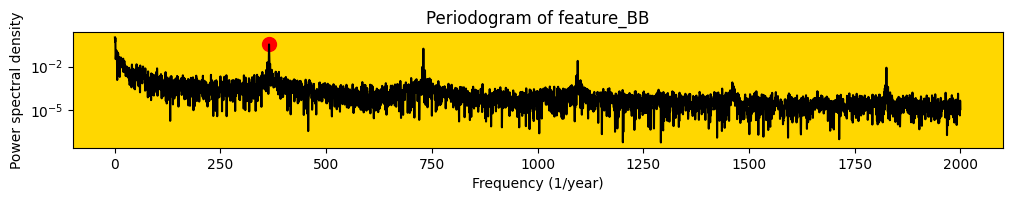

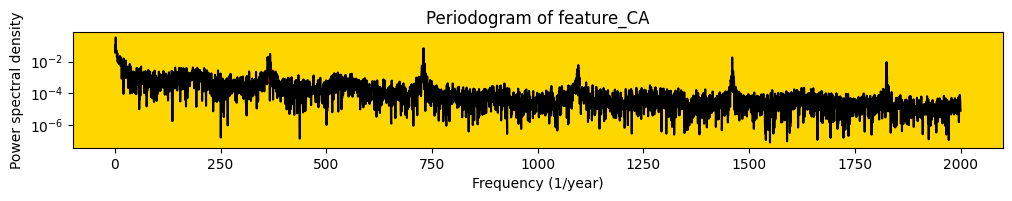

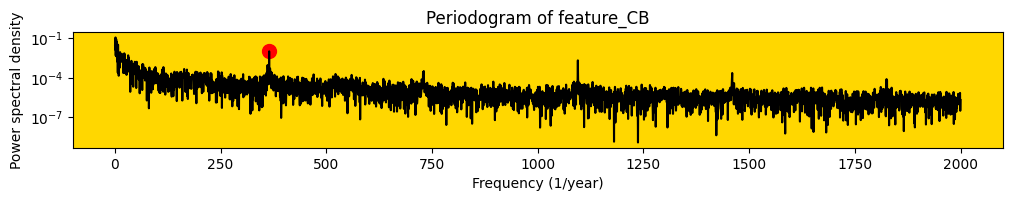

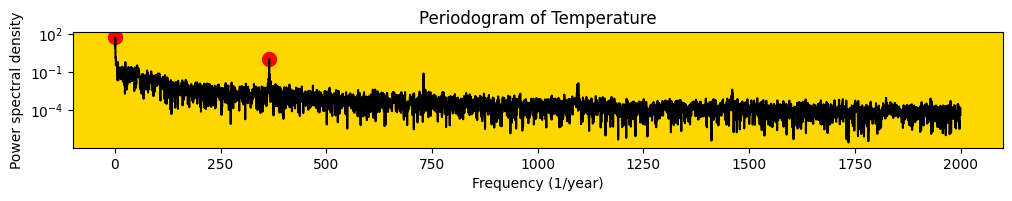

In [7]:
# Plot daily averages and periodograms
for f in features + ['Temperature']:
    ff, Pxx = scipy.signal.periodogram(train[f], 4*24 * 365, detrend='linear')
    # ff = frequency in 1/year
    plt.figure( figsize=(12, 1.5))
    ax = plt.gca()
    ax.set_facecolor('#ffd700') # yellow
    f_max = 2000
    ax.semilogy(ff[ff <= f_max][1:], Pxx[ff <= f_max][1:], color='k')
    index = np.argmax(ff >= 365)
    ax.scatter([365], Pxx[index], color='r', s=100)
    if f == 'Temperature':
        index = np.argmax(ff >= 1)
        ax.scatter([1], Pxx[index], color='r', s=100)
    ax.set_xlabel('Frequency (1/year)')
    ax.set_ylabel('Power spectral density')
    ax.set_title(f'Periodogram of {f}', color='k')

    plt.show()

### The daily pattern¶
The periodogram suggests that there is a daily recurring pattern. We make the pattern visible by plotting the average temperature for every time of day and see that afternoons are two degrees warmer than mornings.

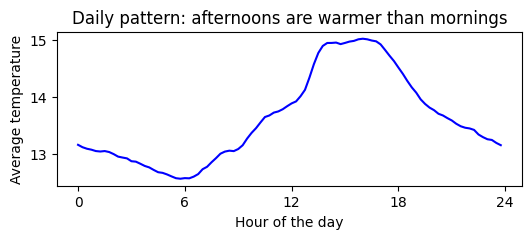

In [21]:
temp = train.Temperature.groupby((train.date - train.date.dt.normalize()).dt.seconds / 3600).mean()

plt.figure(figsize=(6, 2))
plt.plot(temp.index, temp, color='b')
plt.xticks([0, 6, 12, 18, 24])
plt.title("Daily pattern: afternoons are warmer than mornings")
plt.xlabel("Hour of the day")
plt.ylabel("Average temperature")
plt.show()

### Feature engineering¶
In time series prediction, we first of all have to get the trend and the seasonalities right. For this purpose, we add five features to the dataset.

In [23]:
for df in [train, test]:
    df['trend'] = (df.date - train.date.iloc[0]).dt.total_seconds() / 60 / 15
    df['day_cos'] = np.cos(df.trend / 96 * 2 * math.pi)
    df['day_sin'] = np.sin(df.trend / 96 * 2 * math.pi)
    df['year_cos'] = np.cos(df.trend / 96 / 365 * 2 * math.pi)
    df['year_sin'] = np.sin(df.trend / 96 / 365 * 2 * math.pi)

all_features = list(test.columns[1:]) # without date
all_features

['feature_AA',
 'feature_AB',
 'feature_BA',
 'feature_BB',
 'feature_CA',
 'feature_CB',
 'trend',
 'day_cos',
 'day_sin',
 'year_cos',
 'year_sin']

### Point predictions¶

In [24]:
feature_subset = ['trend', 'day_cos', 'day_sin', 'year_cos', 'year_sin', 'date']

def fit_predict_all_quantiles(model, date_tr, X_tr, y_tr, X_te):
    """Fit, calibrate and predict
    
    Splits date_tr, X_tr, y_tr into training and calibration set, fits the model
    for point predictions to the training set, calibrates all quantiles to the 
    calibration set and then predicts all quantiles for X_te
    
    Parameters
    model: a point-prediction regression model
    date_tr: 1d array of shape (n_samples, ) of datetimes
    X_tr: 2d array of shape (n_samples, n_features)
    y_tr: 1d array of shape (n_samples, )
    X_te: 2d array of shape (n_samples_test, n_features)
    
    Return value
    predictions_df: dataframe of shape (n_samples_test, 21)
    """
    # Split into training and calibration
    split_date = date_tr.max() - pd.to_timedelta(28, unit='D') # use 28 days for calibration
    mask_tr = date_tr <= split_date
    X_tr, X_ca = X_tr[mask_tr], X_tr[~mask_tr]
    y_tr, y_ca = y_tr[mask_tr], y_tr[~mask_tr]
#         print(f'Train {len(X_tr)} calibrate {len(X_ca)} predict {len(X_te)}')

    # Fit, predict for calibration, compute residuals 
    model.fit(X_tr, y_tr)
    y_ca_pred = model.predict(X_ca)
    residuals = y_ca - y_ca_pred

    # Determine the quantiles of the residuals
    qs = [0.025, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30,
                 0.35,  0.40, 0.45, 0.50, 0.55, 0.60, 0.65,
                 0.70,  0.75, 0.80, 0.85, 0.90, 0.95, 0.975]
    quantiles = [(q, np.quantile(residuals, q)) for q in qs]

    y_va_pred = model.predict(X_te)
    predictions_df = pd.DataFrame({q: y_va_pred + quantile for (q, quantile) in quantiles})
    return predictions_df

def cross_validate_probabilistic(model, label=None):
    """Cross-validate a model
    
    Cross-validates the model with four time-series splits and outputs
    the continuous ranked probability scores (CRPS) and a diagram.
    """
    if label is None:
        label = type(model).__name__
    print()
    print(label)
    tss = TimeSeriesSplit(n_splits=11)
    dates, oof, y_true = [], [], []
    for fold, (idx_tr, idx_va) in enumerate(tss.split(train)):
        if fold <= 6: continue
        X_tr = train.iloc[idx_tr].copy()[feature_subset + ['Temperature']]
        X_va = train.iloc[idx_va].copy()[feature_subset + ['Temperature']]
        date_tr = X_tr.pop('date')
        date_va = X_va.pop('date')
        y_tr = X_tr.pop('Temperature')
        y_va = X_va.pop('Temperature')

        predictions_df = fit_predict_all_quantiles(model, date_tr, X_tr, y_tr, X_va)
        crps = us.crps(predictions_df, y_va.to_frame())
        print(f"Fold {fold:2}: CRPS={crps:.4f}")
        dates.append(date_va)
        oof.append(predictions_df)
        y_true.append(y_va)

    dates = pd.concat(dates)
    oof = pd.concat(oof, axis=0)
    y_true = pd.concat(y_true)
    crps = us.crps(oof, y_true.to_frame())
    print(f"{Fore.GREEN}Overall  CRPS={crps:.4f}{Style.RESET_ALL}")

    plt.figure(figsize=(12, 2))
    plt.title(f"{label} 90 % coverage")
    plt.ylabel('Temperature')
    plt.xlabel('Date')
    plt.plot(train.date, train.Temperature, label='y_true', color='b')
    plt.fill_between(dates, oof[0.05], oof[0.95],
                     color='y', linewidth=0,
                     label='90 % interval prediction')
    plt.legend()
    plt.show()

model = LinearRegression()
cross_validate_probabilistic(model)

hgb_params = {'max_iter': 100, 'early_stopping': False, 'learning_rate': 0.16, 'max_leaf_nodes': 53, 'min_samples_leaf': 6}
model = HistGradientBoostingRegressor(**hgb_params)
cross_validate_probabilistic(model)



LinearRegression


NameError: name 'us' is not defined